In [122]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from devito import *
from examples.seismic import Model, TimeAxis, Receiver, RickerSource
# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

from plotting import *  

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# === Load data ===
slice_2d = np.load("overthrust_i3_455.npy")

# Convert velocity to km/s if it's in m/s
slice_2d_km = slice_2d / 1000.0

# === Grid parameters ===
n1, n2 = slice_2d.shape
d1 = d2 = 25.0  # meters
x = np.linspace(0, (n2 - 1) * d2 / 1000, n2)  # km
z = np.linspace(0, (n1 - 1) * d1 / 1000, n1)  # km

# === Source and geophones ===
x_source = x[n2 // 2]  # source at 1/4 of profile
num_geophones = 10
x_geophones = np.linspace(x[0], x[-1], num_geophones)

# === Extend borders to show source/geophones ===
z_min = -0.2  # extend 0.1 km above surface
z_max = z[-1]
x_min = x[0] - 0.5  # extend 0.1 km to the left
x_max = x[-1] + 0.5  # extend 0.1 km to the right

 

In [139]:
# ======================================================
# 0. Velocity model from slice_2d (in m/s)
# ======================================================
nz, nx = slice_2d.shape  # depth, width
v = slice_2d.astype(np.float32)  # keep in m/s

# ======================================================
# 1. Define the seismic model
# ======================================================
model = Model(
    origin=(0., 0.),
    shape=(nx, nz),
    spacing=(25.0, 25.0),  # meters
    nbl=40,
    bcs="damp",
    vp=v.T,  # Devito expects (nx, nz)
    space_order=8
)

# ======================================================
# 2. Time axis
# ======================================================
t0 = 0.0
tn = 5.0  # seconds
dt = model.critical_dt * 0.5
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# ======================================================
# 3. Source and receivers
# ======================================================
f0 = 4.0  # Hz
src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range, npoint=1)
src.coordinates.data[0, 0] = model.domain_size[0] / 2
src.coordinates.data[0, 1] = 0.0

nreceivers = 12
rec_coords = np.zeros((nreceivers, 2))
rec_coords[:, 0] = np.linspace(0, model.domain_size[0], nreceivers)
rec_coords[:, 1] = 0.0
rec = Receiver(name='rec', grid=model.grid, time_range=time_range,
               npoint=nreceivers, coordinates=rec_coords)

# ======================================================
# 4. TimeFunction to store wavefield
# ======================================================
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=8,
                 save=time_range.num)

# ======================================================
# 5. PDE, source injection, and receiver interpolation
# ======================================================
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)
op_fwd = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)

# ======================================================
# 6. Run the simulation
# ======================================================
op_fwd(dt=dt)
# ======================================================
# 7. Extract velocity field (without absorbing boundaries)
# ======================================================
velocity_field = model.vp.data[tuple(slice(model.nbl, -model.nbl) for _ in range(2))]
extent = [0, model.domain_size[0], model.domain_size[1], 0]  # meters

# ======================================================
# 8. Extract wavefield at a time instant
# ======================================================
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
max_val = np.abs(u.data[idx_domain_ROI]).max()
time_instant = int(u.data.shape[0] * 0.25)  # 25% of the simulation
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T
# Normalize wavefield for overlay visibility
wave_norm = wavefield / np.abs(wavefield).max()
 

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.72 s


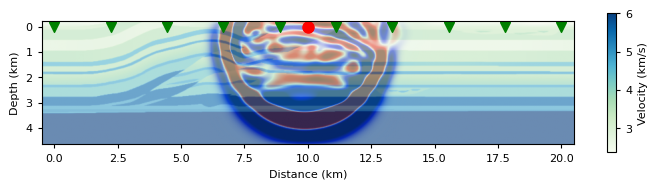

In [153]:


# === Plot ===
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(slice_2d_km, cmap="GnBu", origin="upper",
               extent=[x_min, x_max, z_max, z_min])  # note reversed for depth

ax.imshow(wave_norm, cmap="seismic", alpha=0.4, origin="upper",
          extent=[x_min, x_max, z_max, z_min],
          vmin=-0.2, vmax=0.2)

# Smaller colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.35, aspect=15)
cbar.set_label("Velocity (km/s)")

# Plot source and geophones
ax.plot(x_source, 0, color='red', marker='o', markersize=8, label='Source')        
ax.scatter(x_geophones, np.zeros_like(x_geophones), color='green', marker='v', s=50) 

ax.set_xlabel("Distance (km)")
ax.set_ylabel("Depth (km)")
plt.tight_layout()
plt.show()

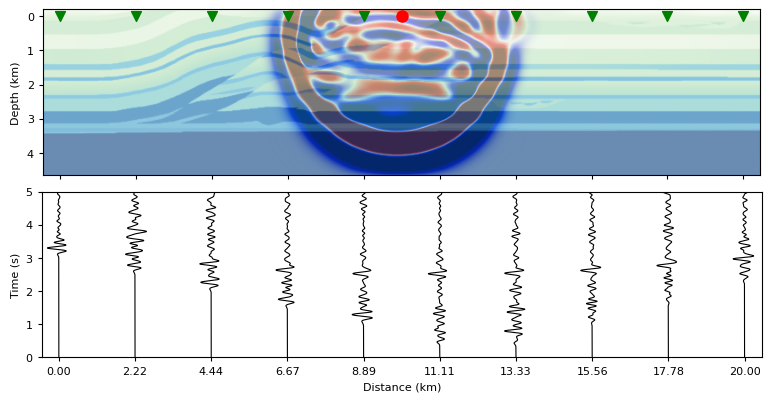

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# === Figure setup ===
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(2, 1, height_ratios=[1, 1], hspace=0.1)  # smaller gap between plots

# === Top plot: Velocity + wavefield ===
ax1 = fig.add_subplot(gs[0])
im = ax1.imshow(slice_2d_km, cmap="GnBu", origin="upper",
                extent=[x_min, x_max, z_max, z_min])

ax1.imshow(wave_norm, cmap="seismic", alpha=0.4, origin="upper",
           extent=[x_min, x_max, z_max, z_min],
           vmin=-0.2, vmax=0.2)

# Plot source and geophones
ax1.plot(x_source, 0, color='red', marker='o', markersize=8, label='Source')
ax1.scatter(x_geophones, np.zeros_like(x_geophones),
            color='green', marker='v', s=50, label='Geophones')

# Labels and style
ax1.set_ylabel("Depth (km)")
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(z_max, z_min)  # depth positive downward
ax1.tick_params(labelbottom=False)

# === Bottom plot: Wiggle seismograms ===
ax2 = fig.add_subplot(gs[1], sharex=ax1)

t = time_range.time_values
scale = 0.15 * (x_geophones[1] - x_geophones[0])  # scale traces relative to spacing

for i, xg in enumerate(x_geophones):
    trace = rec.data[:, i]
    trace_norm = trace / np.max(np.abs(trace))
    ax2.plot(xg + trace_norm * scale, t, color="black", lw=0.8)

#ax2.invert_yaxis()  # time increases downward
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Time (s)")
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(0, t[-1])
# ticks in geophones 
ax2.set_xticks(x_geophones)

# === Layout adjustment ===
plt.subplots_adjust(left=0.08, right=0.98, top=0.97, bottom=0.1, hspace=0.05)
plt.show()


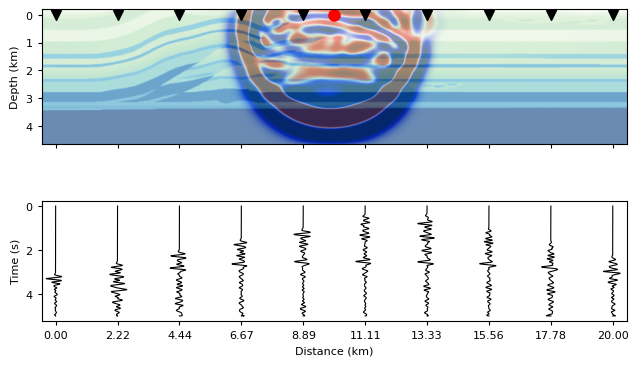

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# === Figure setup ===
fig = plt.figure(figsize=(6.5, 3.5))
gs = GridSpec(2, 1, height_ratios=[1.2, 0.8], hspace=0.22, figure=fig)

# === Compute half-grid correction ===
dx = (x_max - x_min) / slice_2d_km.shape[1]
dz = (z_max - z_min) / slice_2d_km.shape[0]
extent_corrected = [x_min + dx/2, x_max - dx/2, z_max - dz/2, z_min + dz/2]

# === Top plot: Velocity + wavefield ===
ax1 = fig.add_subplot(gs[0])
im = ax1.imshow(slice_2d_km, cmap="GnBu", origin="upper", extent=extent_corrected)
ax1.imshow(wave_norm, cmap="seismic", alpha=0.4, origin="upper",
           extent=extent_corrected, vmin=-0.2, vmax=0.2)

# Plot source and geophones
ax1.plot(x_source, 0, color='red', marker='o', markersize=8)
ax1.scatter(x_geophones, np.zeros_like(x_geophones),
            color='black', marker='v', s=50)

# Labels and limits
ax1.set_ylabel("Depth (km)")
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(z_max, z_min)
ax1.tick_params(labelbottom=False)

# === Bottom plot: Wiggle seismograms ===
ax2 = fig.add_subplot(gs[1], sharex=ax1)

t = time_range.time_values
scale = 0.15 * (x_geophones[1] - x_geophones[0])

for i, xg in enumerate(x_geophones):
    trace = rec.data[:, i]
    trace_norm = trace / np.max(np.abs(trace))
    ax2.plot(xg + trace_norm * scale, t, color="black", lw=0.8)

ax2.invert_yaxis()  # time increases downward
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Time (s)")
ax2.set_xlim(x_min, x_max)
ax2.set_xticks(x_geophones)

# === Add annotations between subplots ===
# fig.text(0.10, 0.51, "Forward", fontsize=10, fontweight="normal",
#          ha="left", va="center")
# fig.text(0.95, 0.51, "Inverse", fontsize=10, fontweight="normal",
#          ha="right", va="center")

# === Save figure with fixed physical size ===
# Avoid bbox_inches='tight' (can change size)
plt.subplots_adjust(left=0.07, right=0.97, top=0.99, bottom=0.13, hspace=0.1)

# Ensure exact physical width = 6.5 in
fig.set_size_inches(6.5, 3.9)
plt.savefig("seismic_wave_propagation.svg", format="svg", dpi=300)
plt.show()
